# Color quantization with scikit-learn

This notebook is part of a blog post on [Geophysics Labs].

Here I demonstrate how to convert a 3-channel RGB picture into an indexed-color one-band grid. This step is essential to be able to import coloured images into OpendTect.

The example shown here makes use of the Kevitsa dataset that was made freely available by the [Frank Arnott Award](https://www.frankarnottaward.com/Home.aspx).
<hr />
Let's start by loading the Numpy and matplotlib libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

## Loading the image
I have an image of the geological map of the Kevitsa area in Finland. This was exported as a PNG image from QGIS.

The image file is read with the matplotlib function `imread`, which converts the image into a Numpy array.

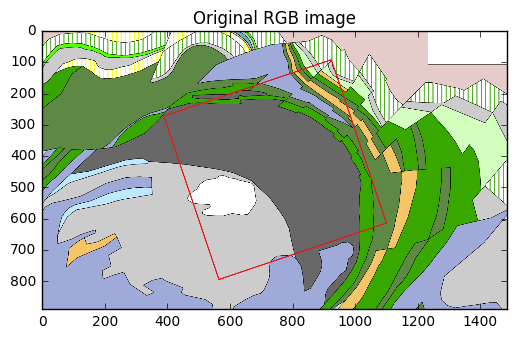

In [2]:
inFile = r'..\data\Kevitsa_geology_noframe.png'
imRGB = plt.imread(inFile)
# plot
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(imRGB)
plt.title('Original RGB image')

Let's check the dimensions of the array:

In [3]:
imRGB.shape

(890, 1485, 4)

Although this is not always the case, this PNG file contains four channels: the three colour bands (red, blue and green) and the alpha channel that stores the transparency information. We need to get rid of it with:

In [4]:
imRGB = imRGB[:,:,:3]

## Color Quantization
We need first to load the palette, which is a list of colours that we consider as fixed.

In [5]:
inFile = r'..\data\Windows_256_color_palette_RGB.csv'
win256 = np.loadtxt(inFile,delimiter=',')

In [6]:
win256[:5]

array([[   0.,    0.,    0.],
       [ 128.,    0.,    0.],
       [   0.,  128.,    0.],
       [ 128.,  128.,    0.],
       [   0.,    0.,  128.]])

Note that the colours are defined with integers ranging from 0 to 255.

*See the end of this notebook in the appendix for an image of the colours present in the palette.*

Next, we have to reshape the array of our RGB image to make sure it fits the same format with one column for each channel.

In [7]:
nrows,ncols,d = imRGB.shape
flat_array = np.reshape(imRGB, (nrows*ncols, 3))
flat_array[:5]

array([[ 0.90196079,  0.79607844,  0.79607844],
       [ 0.90196079,  0.79607844,  0.79607844],
       [ 0.90196079,  0.79607844,  0.79607844],
       [ 0.90196079,  0.79607844,  0.79607844],
       [ 0.90196079,  0.79607844,  0.79607844]], dtype=float32)

Note that in this case, the colours are defined with floats ranging from 0 to 1. Something to keep in mind for the next step.

Now we can compute the colours in the palette that are the closest to the colour of each pixel in our RGB image. This can be done easily using the `pairwise_distances_argmin` function available in the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html#sklearn-metrics-pairwise-distances-argmin) library. 

In [8]:
# import function
from sklearn.metrics import pairwise_distances_argmin
# run function, making sure the palette data is normalised to the 0-1 interval
indices = pairwise_distances_argmin(flat_array,win256/255)
# reshape the indices to the shape of the initial image
indexedImage  = indices.reshape((nrows,ncols))

If we now display our result with a "normal" sequential colormap like *viridis*, we will get a strange image. This is because the plotting function is missing a crucial bit of information, which is the palette that was used to perform the quantization.

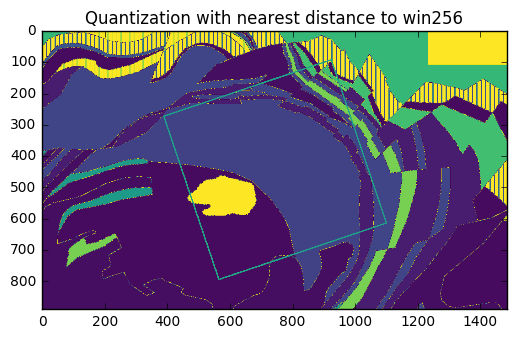

In [9]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(indexedImage,cmap='viridis')
plt.title('Quantization with nearest distance to win256')

To display our indexed-color image properly with matplotlib, we need first to create the appropriate colormap with the colours of the palette. This is done with a function of the `colors` sub-module in [matplotlib](http://matplotlib.org/api/colors_api.html).

In [10]:
new_cm = mcolors.LinearSegmentedColormap.from_list('win256', win256/255)
plt.register_cmap(cmap=new_cm)  # optional but useful to be able to call the colormap by its name.

Let's call `imshow` again with our new colormap. We also need to add the `norm` parameter to prevent `imshow` from normalizing our indices.

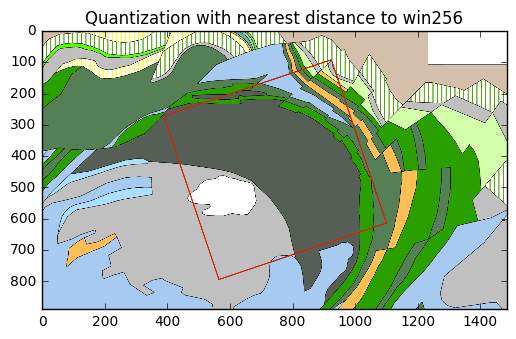

In [11]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(indexedImage,cmap='win256',norm=mcolors.NoNorm())
plt.title('Quantization with nearest distance to win256')

That's it! We can now save the resulting grid to a text file and import it into OpendTect as a 3D horizon. 

However, in our example, there is one more necesssary step. The rotated red square on the image tells us there is a mismatch between the grid of the image and the grid defined by the 3D survey. This can be corrected by interpolation and this is the subject of the next notebook.

For now, we can simply save the array in a NPY file.

In [12]:
outFile = r'..\data\Kevitsa_geology_indexed.npy'
np.save(outFile,indexedImage)

# Appendix: how to display the colors in a colormap

Here is a handy piece of code to display the 256 colours of the palette as individual squares.

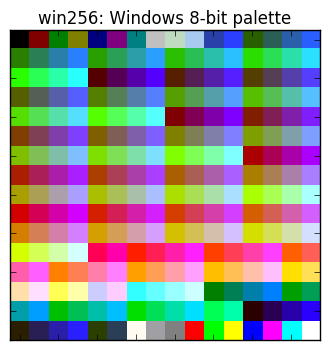

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(np.arange(256).reshape(16, 16),
          cmap = 'win256',
          interpolation="nearest", aspect="equal")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.set_title('win256: Windows 8-bit palette')